In [183]:
 #We'll be using TF 2.1 and torchaudio

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio==0.5.0
!pip install numpy==1.19.5


In [ ]:
#Connecting Drive to save model checkpoints during training and to use custom data, uncomment if needed

# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Permute, Lambda, Embedding, Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [3]:
#Hyperparameters

hop=80               #hop size (window size = 6*hop)
sr=22050              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
bs = 16               #batch size
delta = 2.            #constant for siamese loss

In [4]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

""" ********************NOTE: This is used for mel-spectrogram generation through torchaudio and waveform reconstruction through a gradient based method. It's offline; this means, it's
used during training. CONSIDER if it will be necessary to alter the waveform reconstruction if extra input (encoding) is added. """

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor') #Requires GPU

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True) #Transform that creates spectrogram from audio signal
specfunc = specobj.forward 
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.) #Turns STFT into a mel frequency STFT
melfunc = melobj.forward

def melspecfunc(waveform): #function that transforms audio file into spectrogram
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def spectral_convergence(input, target): #Unsure what this is. I assume it's a method for calculating spectral difference
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003): #For waveform reconstruction, a gradient-based method is used:

    spec = torch.Tensor(spec) #takes in spectrogram
    samples = (spec.shape[-1]*hop)-hop #takes last dimension 

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu() #detach returns new tensor detached from current graph, with a different shape

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1) #-1,1 normalization

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db #denormalization

def prep(wv,hop=80):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu()) #I believe this is for online spectrogram creation. Transforms tensor
  S = librosa.power_to_db(S)-ref_level_db #by changing shape, turning it into mel, squeezing it, detaching from graph, operating in cpu and turning into np.
  return normalize(S) #it then transforms it to db 

def deprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8) #reconstruction of waveform through denormalisation, return to power and gradient method
  return np.array(np.squeeze(wv))

In [5]:
#Helper functions

#Generate spectrograms from waveform array
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object) #return array of certain size without initializing entries
  for i in range(data.shape[0]):
    x = data[i]
    S=prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  print(specs.shape)
  return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*22050):
  x, sr = librosa.load(path,sr=22050)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)


  

In [6]:
speaker_ids = {'F01':1, 'F03':2, 'F04':3, 'M01':4, 'M02':5, 'M03':6, 'M04':7, 'M05': 8}

def create_speaker_vector(speaker_dict):
  speaker_codes = []
  for key, value in speaker_dict.items():
    speaker_codes.append(value * 1.11111)
  
  return speaker_codes

speaker_codes = create_speaker_vector(speaker_ids)



In [8]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms


##SPEAKER EMBEDDINGS - Maybe we can process all input files separately, add a hash at the very beginning here, and then add them all to the adata array. 
#Then, during training, the generator will be fed a different array depending on the hash that is present on the spectrogram


#CONTROL1

awv = audio_array('/content/INP')   
aspec = tospec(awv)                                                            
adata = splitcut(aspec)      
print(adata.shape)



#DYSARTHRIC 1
m01wv = audio_array('/content/M01')
m02wv = audio_array('/content/M02')
#m03wv = audio_array()
#m04wv = audio_array()
#m05wv = audio_array()
#f01wv = audio_array()
#f03wv = audio_array()
#f04wv = audio_array()

m01spec = tospec(m01wv)
m02spec = tospec(m02wv)
#m03spec = tospec(m03wv)
#m04spec = tospec(m04wv)
#m05spec = tospec(m05wv)
#f01spec = tospec(f01wv)
#f03spec = tospec(f03wv)
#f04spec = tospec(f04wv)


m01chunks = splitcut(m01spec)
print(f"m01chunks: {m01chunks.shape}")
#We create another vector of the shape of the chunks
batch,mels,timedim,extra = m01chunks.shape #(x, 80, 240, 1)
#That vector will be adapted to the target speaker
target_vector_m01 = np.ones((batch,1,timedim,extra)) * speaker_ids['M01']
print(target_vector_m01.shape)
#We concatenate that target vector to the chunks to be able to identify the spectrogram at training.
#We will drop this extra dimension after identifying the spectrogram
m01chunks = np.concatenate([m01chunks, target_vector_m01], axis=1)
print(f"After concatenation shape of m01chunks: {m01chunks.shape}")

#See if it gives an error and then change hop if necessary

#We follow the same steps for all speakers

m02chunks = splitcut(m02spec)
batch,mels,timedim,extra = m02chunks.shape #(x, 80, 240, 1)
target_vector_m02 = np.ones((batch,1,timedim,extra)) * speaker_ids['M02']
#print(target_vector_m02[0])
m02chunks = np.concatenate([m02chunks, target_vector_m02], axis=1)
print(f"Shape of m02chunks after concat: {m02chunks.shape}")



#m03chunks = splitcut(m03spec)
#m04chunks = splitcut(m04spec)
#m05chunks = splitcut(m05spec)
#f01chunks = splitcut(f01spec)
#f03chunks = splitcut(f03spec)
#f04chunks = splitcut(f04spec)

  
#After preprocessing, join all chunks into input file bdata
bdata = np.append(m01chunks, m02chunks, axis=0) 

#bdata = np.append(m01chunks, m02chunks, m03chunks, m04chunks, m05chunks, f01chunks, f03chunks, f04chunks, axis=0) 

#print(bdata[15][1][0][0]) #Chunk from M01 speaker
#print(bdata[20][1][0][0]) #Chunk from M02 speaker
print(bdata.shape)


(3,)
(15, 80, 240, 1)
(2,)
(3,)
m01chunks: (19, 80, 240, 1)
(19, 1, 240, 1)
After concatenation shape of m01chunks: (19, 81, 240, 1)
Shape of m02chunks after concat: (24, 81, 240, 1)
(43, 81, 240, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [9]:
#Creating Tensorflow Datasets

@tf.function
def procb(x):
  return tf.image.random_crop(x, size=[hop+1, 3*shape, 1]) #hop is only changed for b dataset to add the speaker code. It will be cropped again before training.

def proca(x):
  return tf.image.random_crop(x, size=[hop, 3*shape, 1]) 

#Problem with code for embeddings is found here - doing dataset_from_tensor_slice, as well as map, makes the code change position to a random place
dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(50).map(proca, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(50).map(procb, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)

In [ ]:
"""#BATCH DATASET B
m01value = [4.]
m02value = [5.]

true_counter = 0
false_counter = 0
total_counter = 0

for spec in dsb:
  #print(spec.shape)
  for batch in spec:
    total_counter += 1
    speaker_value = batch[-1][-1]
    if speaker_value == m01value:
      #print(True)
      true_counter += 1
    else:
      #print(False)
      false_counter += 1
    #print(batch[-1])

print(true_counter)
print(false_counter)
print(total_counter)"""

'#BATCH DATASET B\nm01value = [4.]\nm02value = [5.]\n\ntrue_counter = 0\nfalse_counter = 0\ntotal_counter = 0\n\nfor spec in dsb:\n  #print(spec.shape)\n  for batch in spec:\n    total_counter += 1\n    speaker_value = batch[-1][-1]\n    if speaker_value == m01value:\n      #print(True)\n      true_counter += 1\n    else:\n      #print(False)\n      false_counter += 1\n    #print(batch[-1])\n\nprint(true_counter)\nprint(false_counter)\nprint(total_counter)'

In [10]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [11]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET style architecture
def build_generator(input_shapes):
  h,w,c = input_shapes # 80, 24, 1, except at test time, where batch size usually > 16
  # Inputs
  inp = Input(shape=input_shapes) # shape: 80, 24, 1
  speaker_v_input = Input(shape=(w))
  print(f"Shape of speaker input: {speaker_v_input.shape}") #None, 24
  # Getting embeddings
  embedding_out = tf.keras.layers.Embedding(8, 2, input_length=w)(speaker_v_input) # assume 8 possible speakers, 2 is the dimensionality of embedding.> None, 24, 2
  print(f"Embedding out shape: {embedding_out.shape}")
  #Change shape to (None, 2, 24)
  embedding_out = Permute([2,1])(embedding_out) #None, 2, 24
  embedding_out = tf.expand_dims(embedding_out, axis=-1) #None, 2, 24, 1
  concat_out = Concatenate(axis=1)([inp, embedding_out]) # Concatenate embedding to input > None, 82, 24, 1
    
  # Processing concatenated input
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(concat_out)
  g1 = conv2d(g0, 256, kernel_size=(h+2,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  print(f"Shape of g6: {g6.shape}")
  
  return Model([inp, speaker_v_input],g6, name='G')


#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=(input_shape))

  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=(h,w,c)) # shape: 80, 24
  print(f"Input shape of critic: {inp.shape}")

  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  print(f"Critic after flattening: {g4}")
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  print(g4)
  return Model(inp, g4, name='C')

In [12]:
#Load past models from path to resume training or test
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
  return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
  sw = True
  while sw:
    a = np.random.choice(aspec)
    if a.shape[1]//shape!=1:
      sw=False
  dsa = []
  if a.shape[1]//shape>6:
    num=6
  else:
    num=a.shape[1]//shape
  rn = np.random.randint(a.shape[1]-(num*shape))
  for i in range(num):
    im = a[:,rn+(i*shape):rn+(i*shape)+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
  #Change this so it accommodates to different speakers
  a = testgena()
  print(a.shape)
  bs = a.shape[0]
  generating_vec = np.full(shape=(bs,24), fill_value=2) #We create a different speaker vector at test time, since the batch size wil be != 16
  ab = gen([a,generating_vec], training=False) #Change if we want to vary the speakers
  print("Results mid-training for generation of random spectrograms and audio files. ")
  #gen.summary()
  ab = testass(ab)
  a = testass(a)
  abwv = deprep(ab)
  awv = deprep(a)
  sf.write(path+'/new_file.wav', abwv, sr)
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(np.flip(a, -2), cmap=None)
  axs[0].axis('off')
  axs[0].set_title('Source')
  axs[1].imshow(np.flip(ab, -2), cmap=None)
  axs[1].axis('off')
  axs[1].set_title('Generated')
  plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='../content/'):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
  if epoch % n_save == 0:
    print('Saving...')
    path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
    os.mkdir(path)
    gen.save_weights(path+'/gen.h5')
    critic.save_weights(path+'/critic.h5')
    siam.save_weights(path+'/siam.h5')
    #save_test_image_full(path)

In [13]:
#Losses

def mae(x,y):
  return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa,sa1):
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [14]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

In [180]:

import sys
def check_target(target_spec):

  print("Inside check_target")
  target_vec = np.random.rand(16,24)
  m01value = [4.]
  m02value = [5.]
  imaginaryvalue = [12123.]
  loop_n = -1

  print(f"target_spec.shape: {target_spec.shape}")

  for example in target_spec:
    loop_n += 1
    for code in example[-1][-1]:
      if tf.math.equal(code, m01value) == True:
        target_vec[loop_n] = np.ones((1, shape)) * 4 
        tf.print(code, output_stream=sys.stdout)
        print(f"Speaker is M01")
        print(target_vec[loop_n])
      elif tf.math.equal(code, m02value) == True:
        target_vec[loop_n] = np.ones((1, shape)) * 5
        tf.print(code, output_stream=sys.stdout)
        print(f"Speaker is M02")
        print(target_vec[loop_n]) 
      elif tf.math.equal(code, imaginaryvalue) == True:
        print("NOT WORKING")

  return target_vec[loop_n]




In [181]:
#Check_target works outside of training.
#Why is it not working during training, and it returns all values at the same time? 
#That seems to be the problem, as the loss goes up and down. It seems like the target_vector is being assigned randomly
#What if each batch has multiple speakers??

counter = 0
for batchi,(a,b) in enumerate(zip(dsa,dsb)): #Using this because it's what is being used during training (16,81,24,1)
  target_v = check_target(b)
  print(target_v)
  break



Inside check_target
target_spec.shape: (16, 81, 72, 1)
5
Speaker is M02
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
4
Speaker is M01
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
5
Speaker is M02
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
4
Speaker is M01
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
4
Speaker is M01
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
4
Speaker is M01
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
5
Speaker is M02
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
5
Speaker is M02
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
4
Speaker is M01
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
4
Speaker is M01
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
4
Speaker is M01
[4. 4. 4. 4. 4. 4.

In [176]:
#Training Functions

#Train Generator, Siamese and Critic

@tf.function
def train_all(a,b):
  #splitting spectrogram in 3 parts
  target_speaker = check_target(b)
  print(f"B SHAPE: {b.shape}")
  print(f"A SHAPE: {a.shape}")
  bcropped = tf.image.random_crop(b, size=[bs, 80, 72, 1]) #crop 81st dimension that has the speaker identity values
  aa,aa2,aa3 = extract_image(a) 
  print(f"B SHAPE AFTER CROPPING: {bcropped.shape}")
  bb,bb2,bb3 = extract_image(bcropped)
  #print(f"Target values: {bb[1][1][0]}")

  with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

    print(f"target_speaker shape: {target_speaker.shape}")
    fab = gen([aa, target_speaker], training=True)
    fab2 = gen([aa2, target_speaker], training=True)
    fab3 = gen([aa3, target_speaker], training=True)
    #identity mapping B to B                                                        COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
    fid = gen([bb, target_speaker], training=True) 
    fid2 = gen([bb2, target_speaker], training=True)
    fid3 = gen([bb3, target_speaker], training=True)
    #concatenate/assemble converted spectrograms
    fabtot = assemble_image([fab,fab2,fab3])
    #print(f"Fabtot shape: {fabtot.shape}")
    #print("GENERATOR SUMMARY")
    #gen.summary()

    #feed concatenated spectrograms to critic
    cab = critic(fabtot, training=True)
    cb = critic(bcropped, training=True)
    #print("CRITIC SUMMARY ")
    #critic.summary()D

    #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
    
    sab = siam(fab, training=True)
    sab2 = siam(fab3, training=True)
    sa = siam(aa, training=True)
    sa2 = siam(aa3, training=True)
    #print("SIAMESE SUMMARY")
    #siam.summary()

    #identity mapping loss
    loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                         #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
    #travel loss
    loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
    #generator and critic losses
    loss_g = g_loss_f(cab)
    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)
    loss_d = (loss_dr+loss_df)/2.
    #generator+siamese total loss
    lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)
  
  #computing and applying gradients
  grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
  opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))
  
  return loss_dr,loss_df,loss_g,loss_id

#Train critic only
@tf.function
def train_d(a,b):
  aa,aa2,aa3 = extract_image(a)
  target_speaker = check_target(b)
  bcropped = tf.image.random_crop(b, size=[bs, 80, 72, 1])

  with tf.GradientTape() as tape_disc:

    fab = gen([aa,target_speaker], training=True)
    fab2 = gen([aa2,target_speaker], training=True)
    fab3 = gen([aa3,target_speaker], training=True)
    fabtot = assemble_image([fab,fab2,fab3])

    cab = critic(fabtot, training=True)
    cb = critic(bcropped, training=True)

    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)

    loss_d = (loss_dr+loss_df)/2.
  
  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

  return loss_dr,loss_df

In [177]:

#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5):
  
  update_lr(lr)
  df_list = []
  dr_list = []
  g_list = []
  id_list = []
  c = 0
  g = 0
  
  for epoch in range(epochs):
        #bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi%gupt==0:
              dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
              dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%600==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        #print(f'Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0

In [178]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=False, path='../content/drive/My Drive/')

Shape of speaker input: (None, 24)
Embedding out shape: (None, 24, 2)
Shape of g6: (None, 80, 24, 1)
Input shape of critic: (None, 80, 72, 1)
Critic after flattening: KerasTensor(type_spec=TensorSpec(shape=(None, 9216), dtype=tf.float32, name=None), name='flatten_13/Reshape:0', description="created by layer 'flatten_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_sn_6/BiasAdd:0', description="created by layer 'dense_sn_6'")
Built networks


In [179]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

train(10, batch_size=bs, lr=0.0002, n_save=1, gupt=5)

Inside check_target
target_spec.shape: (16, 81, 72, 1)


NotImplementedError: ignored

In [ ]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  print(imlast.shape)
  dsa.append(imlast)
  print(np.array(dsa, dtype=np.float32).shape)

  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec) #Chop source spectrogram into chunks of equal size
  print(f"specarr: {specarr.shape}")
  a = specarr 
  batch_size = specarr.shape[0]
  testing_vector = np.ones((batch_size, shape)) * 4
  #print(testing_vector)
  ab = gen([a, testing_vector], training=False) 
  #gen.summary()
 
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

(56448,)


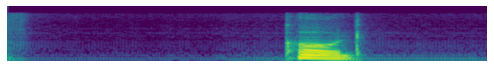

(80, 24, 1)
(30, 80, 24, 1)
specarr: (30, 80, 24, 1)
Assembling and Converting...


 62%|██████▏   | 1240/2000 [00:01<00:01, 674.85it/s, loss=0.00868, spectral_convergence=-15.5]


KeyboardInterrupt: ignored

In [ ]:
#Wav to wav conversion

wv, sr = librosa.load('/content/test/MC01_30005.wav', sr=22050)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME12', path='../content/')           #Convert and save wav